In [1]:
import math
import numpy as np
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display, Math
import requests
import datetime
from typing import Optional

# My favorite figure's settings
set_matplotlib_formats('svg')
mpl.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['font.size'] = '16.'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'].remove('Times New Roman')
# plt.rcParams['font.serif'].insert(0, 'Times New Roman')
plt.rcParams['font.serif'].insert(0, 'Iowan Old Style BT')
plt.rcParams['font.sans-serif'].insert(0, 'SF Pro Text')

In [2]:
r = requests.get(
    r'https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv'
)
now = datetime.datetime.now().strftime('%Y%m%d')
lines = r.text.strip().split('\r\n')
prefectures = lines[0].split(',')[1:]
date = []
values = []
for line in lines[1:]:
    tmp = line.split(',')
    d = list(map(int, tmp[0].split('/')))
    date.append(datetime.date(*d))
    values.append([int(s) for s in tmp[1:]])
date = np.array(date)
values = np.array(values)
date[-1]

datetime.date(2022, 1, 25)

In [3]:
def plot_prefecture(
    date: np.ndarray,
    value: np.ndarray,
    prefecture: str,
    timestamp: str,
    xlim: tuple[float, float],
    ylim: tuple[float, float],
    tag: Optional[str] = None,
    save: bool = True,
) -> tuple[mpl.figure.Figure, ...]:
    if prefecture == 'ALL':
        prefecture = 'Japan'
    value_smoothed = np.convolve(np.ones(7) / 7, value, 'same')[:-3]
    value_smoothed2 = np.convolve(np.ones(14) / 14, value, 'same')[:-7]
    date_smoothed = date[: value_smoothed.size]
    date_smoothed2 = date[: value_smoothed2.size]

    a, b, c = lsm(date2num(date_smoothed[-3:]), value_smoothed[-3:])
    a2, b2, c2 = lsm(date2num(date_smoothed2[-3:]), value_smoothed2[-3:])
    locator = mdates.MonthLocator(bymonth=range(1, 13, 2))
    formatter = mdates.DateFormatter('%b\n%Y')
    date_plot = np.arange(30) + date[-1].toordinal()

    figures = []
    figures.append(plt.figure(constrained_layout=True))
    ax = plt.gca()
    ax.plot(date, value, label='Original')
    ax.plot(
        date_smoothed,
        value_smoothed,
        color='r',
        linewidth=2,
        label='7 days avg.',
    )
    ax.plot(
        date_smoothed2,
        value_smoothed2,
        color='g',
        linewidth=2,
        label='14 days avg.',
    )
    ax.plot(
        num2date(date_plot),
        exp_delay(date_plot, a, b, c),
        'r--',
        label='7 days avg. (Est.)',
    )
    ax.plot(
        num2date(date_plot),
        exp_delay(date_plot, a2, b2, c2),
        'g--',
        label='14 days avg. (Est.)',
    )
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cases in {}'.format(prefecture))
    ax.set_xlim(*xlim)
    ax.set_ylim(0, ylim[1])
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.legend(fontsize=12, loc='best')
    ax.grid()
    plt.title(date[-1].strftime('Until %b %d, %Y'))
    if save:
        basename = 'figs/positives_plot'
        filename = basename + '_{}_{}'.format(timestamp, prefecture)
        if tag:
            filename += '_' + tag
        # plt.savefig(
        #     filename + '.png',
        #     dpi=600,
        # )
        plt.savefig(filename + '.svg')

    figures.append(plt.figure(constrained_layout=True))
    ax = plt.gca()
    ax.semilogy(date, value, label='Original')
    ax.semilogy(
        date_smoothed,
        value_smoothed,
        color='r',
        linewidth=2,
        label='7 days avg.',
    )
    ax.semilogy(
        date_smoothed2,
        value_smoothed2,
        color='g',
        linewidth=2,
        label='14 days avg.',
    )
    ax.semilogy(
        num2date(date_plot),
        exp_delay(date_plot, a, b, c),
        'r--',
        label='7 days avg. (Est.)',
    )
    ax.semilogy(
        num2date(date_plot),
        exp_delay(date_plot, a2, b2, c2),
        'g--',
        label='14 days avg. (Est.)',
    )
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Cases in {}'.format(prefecture))
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.legend(fontsize=12, loc='best')
    ax.grid()
    plt.title(date[-1].strftime('Until %b %d, %Y'))
    if save:
        basename = 'figs/positives_semilogy'
        filename = basename + '_{}_{}'.format(timestamp, prefecture)
        if tag:
            filename += '_' + tag
        # plt.savefig(
        #     filename + '.png',
        #     dpi=600,
        # )
        plt.savefig(filename + '.svg')
    return tuple(figures)

## Least Square Method

$$\begin{align}
y &= b\exp(ax) \\
\log(y) &= ax + \log(b)
\end{align}$$
Consider the least square method,
$$\begin{align}
\begin{bmatrix}
\log(y_1) \\
\vdots \\
\log(y_n)
\end{bmatrix}
&=
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}
\begin{bmatrix}
a \\
\log(b)
\end{bmatrix}
\end{align}$$

$$
\begin{align}
\begin{bmatrix}
a \\
\log(b)
\end{bmatrix}
&=
\left(\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}^T
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}\right)^{-1}
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}^T
\begin{bmatrix}
\log(y_1) \\
\vdots \\
\log(y_n)
\end{bmatrix}
\end{align}$$

In [4]:
def date2num(x):
    f = np.frompyfunc(lambda x: x.toordinal(), 1, 1)
    return f(x)


def num2date(x):
    f = np.frompyfunc(lambda x: datetime.date.fromordinal(x), 1, 1)
    return f(x)


def lsm(x, y):
    A = np.vstack([x - x.min(), np.ones(x.size)]).astype(np.float64).T
    y = np.log(y)
    b = np.linalg.pinv(A) @ y
    return b[0], np.exp(b[1]), x.min()


def exp_delay(x, a, b, c):
    return b * np.exp(a * (x - c))

In [5]:
def plots(index, start_date, ylim):
    return plot_prefecture(
    date,
    values[:, index],
    prefectures[index],
    now,
    (start_date[0], None),
    ylim,
) + plot_prefecture(
    date,
    values[:, index],
    prefectures[index],
    now,
    (start_date[1], None),
    ylim,
    tag='detail'
)

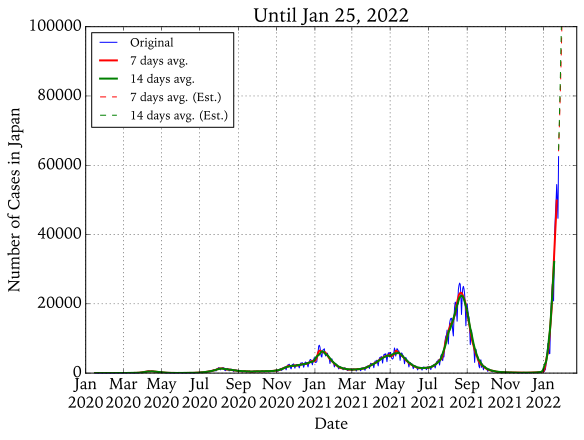

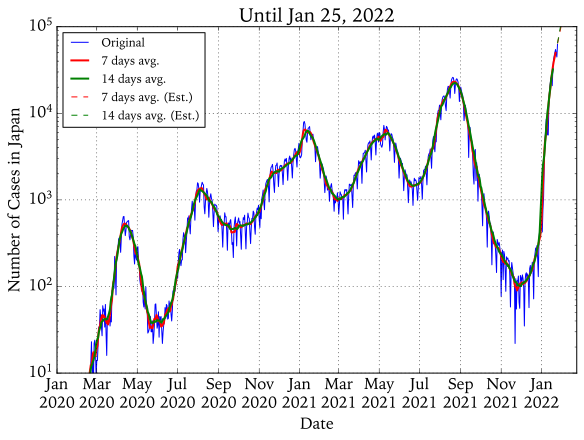

In [6]:
# Japan Part 1
plot_prefecture(
    date,
    values[:, 0],
    prefectures[0],
    now,
    (datetime.date(2020, 1, 1), None),
    (10, 1e5),
    tag='total',
)
plt.show()

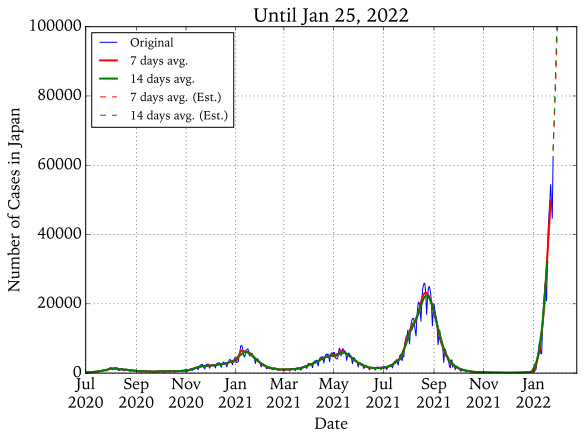

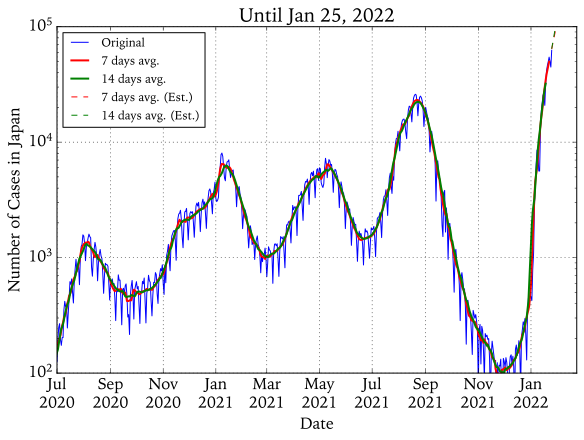

In [7]:
# Japan part 2
plot_prefecture(
    date,
    values[:, 0],
    prefectures[0],
    now,
    (datetime.date(2020, 7, 1), None),
    (100, 1e5),
    tag=None,
    save=True,
)
plt.show()

In [8]:
# Japan Part 3
figs = plot_prefecture(
    date,
    values[:, 0],
    prefectures[0],
    now,
    (datetime.date(2021, 6, 1), None),
    (50, 1e5),
    tag='detail',
    save=True,
)
[fig.clear() for fig in figs]

[None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
# Miyagi
figs = plot_prefecture(
    date,
    values[:, 4],
    prefectures[4],
    now,
    (datetime.date(2020, 7, 1), None),
    (5, 5e2),
) + plot_prefecture(
    date,
    values[:, 4],
    prefectures[4],
    now,
    (datetime.date(2021, 7, 1), None),
    (5, 5e2),
    tag='detail'
)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
start_date = [datetime.date(2020, 7, 1), datetime.date(2021, 7, 1)]

In [11]:
# Miyagi
index = 4
start_date = [datetime.date(2020, 7, 1), datetime.date(2021, 7, 1)]
ylim = (5, 5e2)
figs = plots(index, start_date, ylim)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# Fukushima
index = 7
start_date = [datetime.date(2020, 7, 1), datetime.date(2021, 7, 1)]
ylim = (5, 3e2)
figs = plots(index, start_date, ylim)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
# Tokyo
index = 13
ylim = (5, 2e4)
figs = plots(index, start_date, ylim)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
# Chiba
index = 12
ylim = (5, 5e3)
figs = plots(index, start_date, ylim)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
# Aichi
index = 23
ylim = (5, 6e3)
figs = plots(index, start_date, ylim)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# Kanagawa
index = 14
ylim = (5, 1e4)
figs = plots(index, start_date, ylim)
[fig.clear() for fig in figs]

[None, None, None, None]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>